# Week 9: Support Vector Machines

Up to now, we have approached classification using "generative" models. That is models that generate predicted probabilites and use these to come up with labels for new observations. An example of this would be logistic regression where our predicted probability is of the form:

$$ \pi(X) = \frac{1}{1 + e^{-\beta_0 - \beta_1 X_1 - ... - \beta_p X_p}}$$

we then use our training data to "learn" the parameters $\beta_0, ..., \beta_p$ by minimizing some cost function.

In contrast, a discriminative model will simply attempt to draw a line through the two classes, and decide which class the new observation is by which side of the line it falls on.

*The material below draws heavily from examples in the Python Data Science Handbook by*


In [33]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

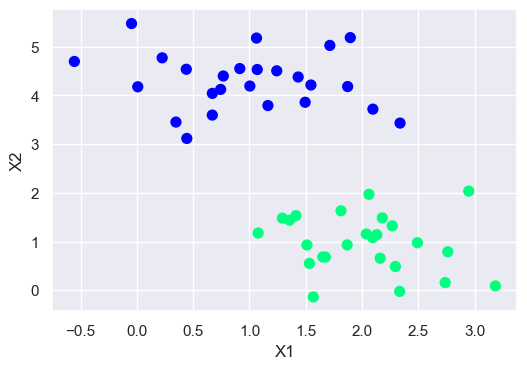

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs 
X, y = make_blobs(n_samples=50, centers=2,
                             random_state=0, cluster_std=0.60)
plt.figure(figsize = (6,4))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

In the example above, it is clear to see that drawing a line that seperates the two classes would be straightforward, we could do this by hand. However, if two people drew lines independently, it's unlikely that their two lines would agree. More broadly, the problem is that there are an infinite number of lines that we could draw to seperate these two classes. The question then becomes: which line to choose?

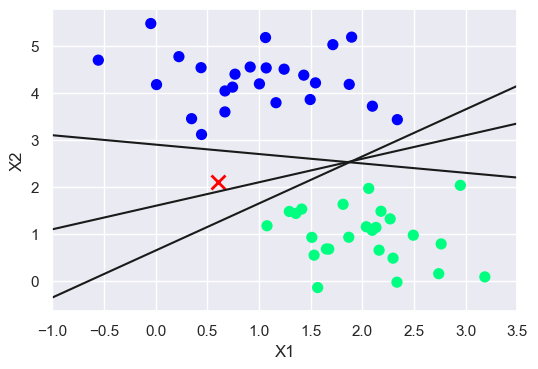

In [51]:
import numpy as np
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (6,4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plt.xlabel("X1")
plt.ylabel("X2")
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]: 
    plt.plot(xfit, m * xfit + b, '-k')
    plt.xlim(-1, 3.5);

## Maximizing the Margin and Imperfect Classification

As we can see above, these three different lines give very different classification rules. Depending on the line that we choose the new observation (labeled as a red $X$) will be classified differently. Support vector machines solve this problem by choosing the "margin", or the distance between the line and the nearest point.

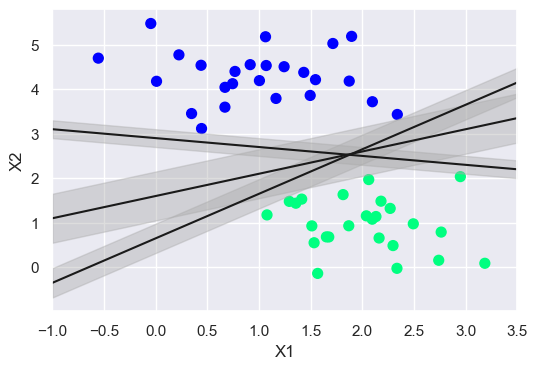

In [52]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (6,4))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]: 
    yfit=m*xfit+b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha = 0.4)
    plt.xlim(-1, 3.5);

We can think of the problem of finding the optimal line as solving a maximization problem, something like:
\begin{align}
&\max \;\;\;\text{Margin between line and nearest point}\\
&\text{ subject to:}\;\;\;\text{ all points correctly classified}
\end{align}

This is all very well when our data is clean and classes are clearly seperated. However, what happens when we cannot perfectly linearly discriminate between the two classes? For example, what if our data looks like the following:

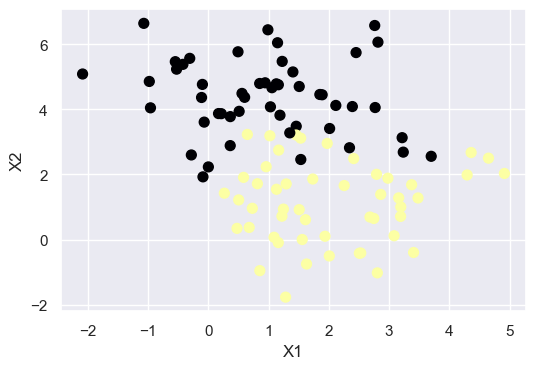

In [53]:
X, y = make_blobs(n_samples=100, centers=2,
                              random_state=0, cluster_std=1.2)
plt.figure(figsize = (6,4))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='inferno');

We can clearly see now that there is no line that we can draw that will perfectly discriminate between the two classes.